In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import cv2
import os

In [4]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [5]:
image_size = 128
images = []
ages = []

In [6]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return []

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(
        grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(40,40)
    )

    crops = []
    for (x, y, w, h) in faces:
        x_max = min(img.shape[1], x + w)
        y_max = min(img.shape[0], y + h)
        x = max(0, x)
        y = max(0, y)

        if w <= 0 or h <= 0:
            continue

        im_cropped = img[y:y_max, x:x_max]
        if im_cropped.size == 0:
            continue

        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
        im_cropped = im_cropped.astype("float32") / 255.0
        crops.append(im_cropped)

    return crops

In [7]:
i = 0
numImg = 2000
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= numImg:
            break
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            processed_crops = preprocess_image(img_path)
            age = int(file.split("_")[0])
            if len(processed_crops) == 0:
                continue
            for crop in processed_crops:
                images.append(crop)
                normalized_age = age / 116
                ages.append(normalized_age)
                i += 1
                if i >= numImg:
                    break

In [8]:
!pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-27 17:43:38.054828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 17:43:38.093811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 17:43:43.584208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, x_train_ages, x_test_ages = train_test_split(
    images, ages, test_size=0.2, random_state=42
)

x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

x_train_ages = np.array(x_train_ages, dtype=np.float32).reshape(-1,1)
x_test_ages = np.array(x_test_ages, dtype=np.float32).reshape(-1,1)

# Crear datasets de tf.data
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train_ages))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test_ages))
val_dataset = val_dataset.batch(batch_size)

print(x_train.shape, x_train_ages.shape)
print(x_test.shape, x_test_ages.shape)


(1600, 128, 128, 3) (1600, 1)
(400, 128, 128, 3) (400, 1)


I0000 00:00:1764261827.357239   66031 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7168 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:

from keras.saving import register_keras_serializable

def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same")(shortcut)
    x = layers.Conv2D(filters, 3, strides=strides, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x
    
def build_encoder(latent_dim):
    inputs = Input(shape=(128, 128, 3))
    age_input = Input(shape=(1,))

    # Down 1 → 64×64
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    # Down 2 → 32×32
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    # Down 3 → 16×16
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # Este skip tiene tamaño 16x16
    skip = x

    # Bottleneck → 16×16
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    # Flatten + age conditioning
    x_flat = layers.Flatten()(x)
    x_flat = layers.Dense(256, activation="relu")(x_flat)

    # Encode age
    age_encoded = layers.Dense(32, activation="relu")(age_input)
    x_flat = layers.Concatenate()([x_flat, age_encoded])

    # Latent space
    z_mean = layers.Dense(latent_dim)(x_flat)
    z_log_var = layers.Dense(latent_dim)(x_flat)

    @register_keras_serializable()
    def sampling(args):
        mean, log_var = args
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * eps

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    return Model([inputs, age_input], [z_mean, z_log_var, z, skip], name="encoder")

In [12]:
def build_decoder(latent_dim):
    z_inputs = Input(shape=(latent_dim,))
    age_input = Input(shape=(1,))

    # ÚNICO SKIP (el de 32x32x128)
    skip = Input(shape=(32, 32, 128))

    # Age embedding
    age_embed = layers.Dense(64, activation="relu")(age_input)
    age_embed = layers.Dense(256, activation="relu")(age_embed)

    # Latent + age (bottleneck)
    x = layers.Concatenate()([z_inputs, age_embed])
    x = layers.Dense(16 * 16 * 256, activation="relu")(x)
    x = layers.Reshape((16, 16, 256))(x)

    # UPSAMPLE 1: 16 → 32
    x = layers.UpSampling2D()(x)

    skip_mod = layers.Conv2D(64, 1, padding="same")(skip)

    x = layers.Concatenate()([x, skip_mod])
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    # -------------------------------------------------------
    # UPSAMPLE 2: 32 → 64
    # -------------------------------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    # -------------------------------------------------------
    # UPSAMPLE 3: 64 → 128
    # -------------------------------------------------------
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    # -------------------------------------------------------
    # Final RGB
    # -------------------------------------------------------
    outputs = layers.Conv2D(3, 1, activation="sigmoid", padding="same")(x)

    # Predicción de edad (opcional)
    flat = layers.Flatten()(x)
    age_pred = layers.Dense(1, activation="linear")(flat)

    return Model([z_inputs, age_input, skip], [outputs, age_pred], name="decoder")

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras_facenet import FaceNet
identity_model = FaceNet().model
identity_model.trainable = False

recon_weight = 10.0
kl_weight = 0.05
p_weight = 0.02
identity_weight = 0.3
age_weight = 0.8

# --- Preparar modelo VGG para perceptual loss ---
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
layer_names = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)

def perceptual_loss(x_true, x_pred):
    # VGG espera imágenes en [0,255], actualmente tus imágenes están en [0,1]
    x_true_pp = preprocess_input(x_true * 255.0)
    x_pred_pp = preprocess_input(x_pred * 255.0)
    
    features_true = vgg_model(x_true_pp)
    features_pred = vgg_model(x_pred_pp)
    
    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += tf.reduce_mean(tf.square(f_true - f_pred))
    return loss

def identity_loss(x_true, x_pred):
    # FaceNet espera 160x160 y [0,255]
    x_true_resized = tf.image.resize(x_true, (160, 160)) * 255.0
    x_pred_resized = tf.image.resize(x_pred, (160, 160)) * 255.0

    emb_true = identity_model(x_true_resized)
    emb_pred = identity_model(x_pred_resized)

    return tf.reduce_mean(tf.square(emb_true - emb_pred))

def age_loss(y_true_age, y_pred_age):
    return tf.reduce_mean(tf.square(y_true_age - y_pred_age))


# --- Clase VAE ---
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, kl_weight=1.0, p_weight=0.5, identity_weight=0.5, age_weight=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.p_weight = p_weight
        self.identity_weight = identity_weight
        self.age_weight = age_weight
        self.recon_weight = recon_weight

    def train_step(self, data):
        x, age_input = data
        with tf.GradientTape() as tape:

            # --- Encoder con skips ---
            outputs = self.encoder([x, age_input], training=True)
            z_mean, z_log_var, z = outputs[:3]
            skip = outputs[3]   # recuperamos los skips

            # --- Decoder con skips ---
            reconstruction, age_pred = self.decoder(
                [z, age_input, skip], 
                training=True
            )

            # Reconstrucción
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            recon_loss = tf.reduce_mean(mae + 0.5*(1-ssim))

            # KL loss
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            # Otros losses
            p_loss = perceptual_loss(x, reconstruction)
            id_loss = identity_loss(x, reconstruction)
            age_loss_value = age_loss(age_input, age_pred)

            total_loss = (self.recon_weight * recon_loss +
                        self.kl_weight * kl_loss +
                        self.p_weight * p_loss +
                        self.identity_weight * id_loss +
                        self.age_weight * age_loss_value)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
            "perceptual_loss": p_loss,
            "identity_loss": id_loss,
            "age_loss": age_loss_value
        }


    def test_step(self, data):
        x, age_input = data

        outputs = self.encoder([x, age_input], training=False)
        z_mean, z_log_var, z = outputs[:3]
        skip = outputs[3]

        reconstruction, age_pred = self.decoder(
            [z, age_input, skip],
            training=False
        )

        mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
        ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
        recon_loss = tf.reduce_mean(mae + 0.5*(1-ssim))

        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

        p_loss = perceptual_loss(x, reconstruction)
        id_loss = identity_loss(x, reconstruction)
        age_loss_value = age_loss(age_input, age_pred)

        total_loss = (self.recon_weight * recon_loss +
                    self.kl_weight * kl_loss +
                    self.p_weight * p_loss +
                    self.identity_weight * id_loss +
                    self.age_weight * age_loss_value)

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
            "perceptual_loss": p_loss,
            "identity_loss": id_loss,
            "age_loss": age_loss_value
        }


    def call(self, inputs):
        x, age_input = inputs
        outputs = self.encoder([x, age_input], training=False)
        _, _, z = outputs[:3]
        skip = outputs[3]

        reconstruction, _ = self.decoder([z, age_input, skip], training=False)
        return reconstruction

In [14]:
latent_dim = 128

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=None)

In [16]:
class SaveEveryN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            vae.build((None,) + x_train.shape[1:])
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"../Models/Temp/vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"../Models/Temp/vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f'../Models/Temp/vae_weights_epoch_{epoch+1}.weights.h5')

In [17]:
# Train
epochs = 5
batch_size = 64

history = vae.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[SaveEveryN()]
)

vae.build((None,) + x_train.shape[1:])


Epoch 1/5


2025-11-27 17:43:59.743853: I external/local_xla/xla/service/service.cc:163] XLA service 0x79d938030040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 17:43:59.743871: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-27 17:44:00.165389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 17:44:00.411697: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-27 17:44:00.411747: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-27 17:44:00.412002: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-27 17:44:00.412409: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignor

 1/50 ━━━━━━━━━━━━━━━━━━━━ 30:31 37s/step - age_loss: 0.0335 - identity_loss: 0.0039 - kl_loss: 0.0225 - loss: 99648.8359 - perceptual_loss: 199287.4531 - reconstruction_loss: 0.5055

I0000 00:00:1764261867.217238   66408 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - age_loss: 4911.9325 - identity_loss: 0.0018 - kl_loss: 182.8363 - loss: 84985.6327 - perceptual_loss: 159772.4688 - reconstruction_loss: 0.4630

2025-11-27 17:44:36.893828: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-27 17:44:36.893896: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-27 17:44:36.894463: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-27 17:44:36.894548: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-27 17:44:43.234712: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-27 17:44:43.234731: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-27 17:44:43.234758: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-27 17:44:43.234769: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator S

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 465ms/step - age_loss: 395.7502 - identity_loss: 5.3512e-04 - kl_loss: 84.5086 - loss: 77280.2344 - perceptual_loss: 153591.2344 - reconstruction_loss: 0.4361 - val_age_loss: 1497.9227 - val_identity_loss: 7.4914e-04 - val_kl_loss: 81.5674 - val_loss: 74024.2422 - val_perceptual_loss: 144880.8281 - val_reconstruction_loss: 0.4340
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - age_loss: 38.6849 - identity_loss: 2.2001e-04 - kl_loss: 39.5617 - loss: 50341.8516 - perceptual_loss: 100519.8906 - reconstruction_loss: 0.3659 - val_age_loss: 81.9006 - val_identity_loss: 2.4845e-04 - val_kl_loss: 40.3608 - val_loss: 48117.3594 - val_perceptual_loss: 95983.7578 - val_reconstruction_loss: 0.3217
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - age_loss: 34.7007 - identity_loss: 1.2277e-04 - kl_loss: 38.1700 - loss: 31169.4453 - perceptual_loss: 62189.2422 - reconstruction_loss: 0.1954 - val_age_loss: 368.1578 - val_identity_loss: 5.5510e-05 - val_kl_loss: 

In [18]:
vae.encoder.save( "../Models/vae_encoder.keras")
vae.decoder.save( "../Models/vae_decoder.keras")

vae.save_weights('../Models/vae_weights.weights.h5')

In [19]:
# encoder = build_encoder(latent_dim)
# decoder = build_decoder(latent_dim)

# vae = VAE(encoder, decoder)

# vae.build((None,) + x_train.shape[1:])
# vae.load_weights("../Models/Temp/vae_weights_epoch_40.weights.h5")

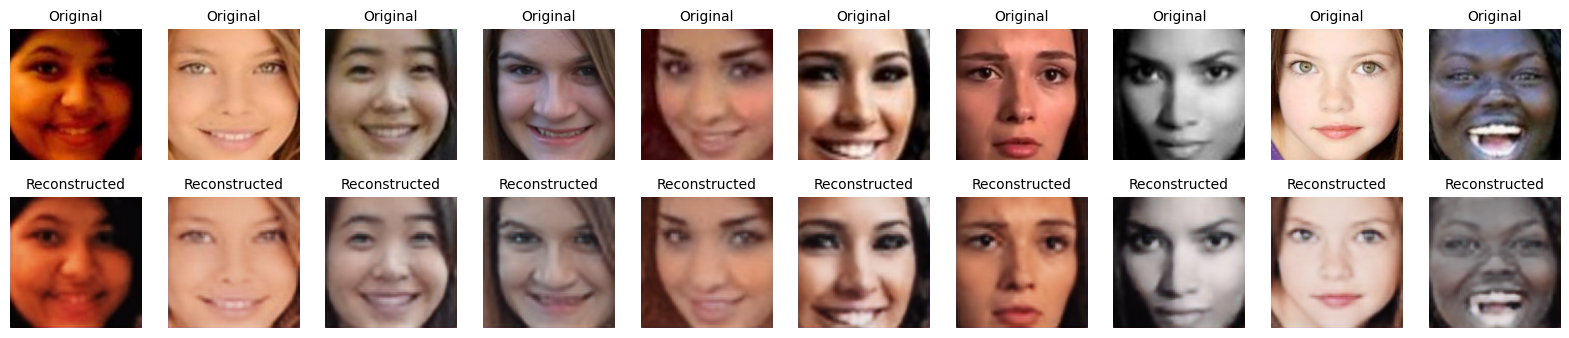

In [20]:
import matplotlib.pyplot as plt

n = 10  # Número de imágenes a mostrar

# Tomar las primeras n imágenes y edades
x_sample = tf.convert_to_tensor(x_test[:n], dtype=tf.float32)
age_sample = tf.convert_to_tensor(x_test_ages[:n], dtype=tf.float32)

# --- Obtener representaciones latentes y skips ---
encoder_outputs = vae.encoder([x_sample, age_sample], training=False)
z_mean, z_log_var, z = encoder_outputs[:3]
skip = encoder_outputs[3]

# --- Decodificar usando skips ---
decoded_imgs, _ = vae.decoder([z, age_sample, skip], training=False)

# --- Mostrar ---
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_sample[i].numpy())
    plt.axis("off")
    plt.title("Original", fontsize=10)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy())
    plt.axis("off")
    plt.title("Reconstructed", fontsize=10)

plt.show()


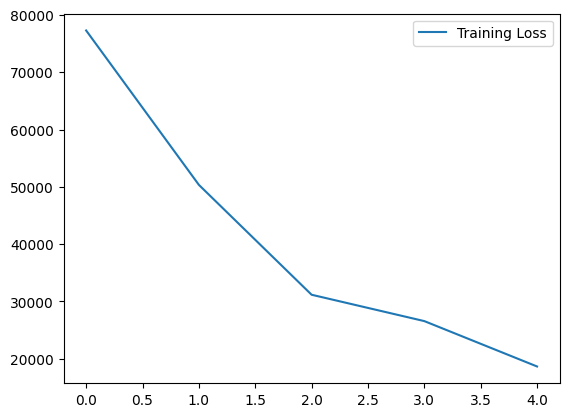

In [21]:
loss = history.history['loss']

epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')
plt.legend()
plt.show()

In [22]:
def generate_age_variations(img_path, ages=[5, 15, 25, 40, 60, 80]):
    """
    Genera múltiples versiones de una imagen con diferentes edades.
    Requiere:
        - vae: modelo entrenado
        - preprocess_image: debe devolver recortes faciales normalizados [0,1]
    """

    # --- Preprocesamiento ---
    face_crops = preprocess_image(img_path)
    if len(face_crops) == 0:
        raise ValueError("No se detectó ninguna cara en la imagen.")

    face = face_crops[0]

    # Batch de tamaño 1
    face_batch = np.expand_dims(face, axis=0)
    face_tensor = tf.convert_to_tensor(face_batch, dtype=tf.float32)

    decoded_results = []

    # --- Procesar cada edad ---
    for age_value in ages:
        age_tensor = tf.convert_to_tensor([[age_value]], dtype=tf.float32)

        # Encode + obtener skips
        enc_out = vae.encoder([face_tensor, age_tensor], training=False)
        z_mean, z_log_var, z = enc_out[:3]
        skip = enc_out[3]

        # Decode con skips
        decoded_img, _ = vae.decoder([z, age_tensor, skip],
                                     training=False)

        decoded_results.append(decoded_img[0].numpy())

    # --- Mostrar ---
    plt.figure(figsize=(3 * len(ages), 4))

    # Mostrar imagen original
    plt.subplot(1, len(ages) + 1, 1)
    plt.imshow(face)
    plt.title("Original")
    plt.axis("off")

    # Mostrar variaciones
    for i, age_value in enumerate(ages):
        plt.subplot(1, len(ages) + 1, i + 2)
        plt.imshow(decoded_results[i])
        plt.title(f"Edad: {age_value}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return decoded_results



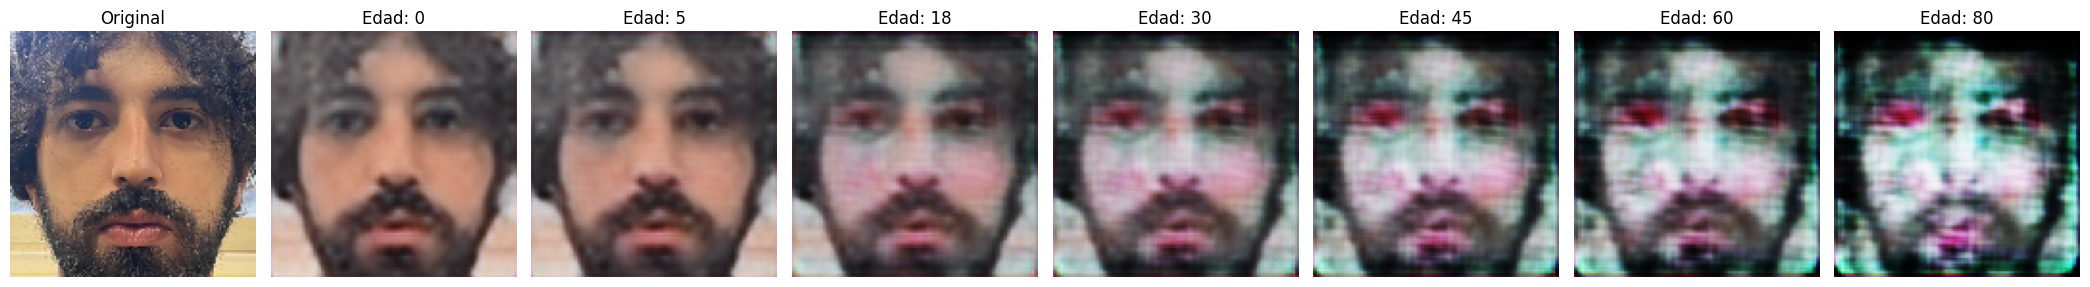

[array([[[0.65610325, 0.5512077 , 0.611311  ],
         [0.66091114, 0.5919457 , 0.6395954 ],
         [0.5835094 , 0.575064  , 0.60738045],
         ...,
         [0.70638967, 0.64350885, 0.6731272 ],
         [0.7000038 , 0.62859577, 0.66634935],
         [0.62789357, 0.58288467, 0.6376106 ]],
 
        [[0.6951678 , 0.5806926 , 0.6485149 ],
         [0.73536843, 0.6338607 , 0.67284095],
         [0.61902684, 0.61620057, 0.63445574],
         ...,
         [0.75119084, 0.689228  , 0.7061383 ],
         [0.7505743 , 0.68459105, 0.687024  ],
         [0.67798084, 0.63454294, 0.6819117 ]],
 
        [[0.71147186, 0.5892543 , 0.71315897],
         [0.7256791 , 0.6793003 , 0.71896815],
         [0.60267454, 0.6635129 , 0.65416604],
         ...,
         [0.7254927 , 0.7208842 , 0.7120541 ],
         [0.76109403, 0.7061649 , 0.72725135],
         [0.73087305, 0.6745871 , 0.71374667]],
 
        ...,
 
        [[0.87198925, 0.71994317, 0.8445347 ],
         [0.9056252 , 0.81165713, 0.75610

In [26]:
generate_age_variations(
    img_path="../Images/A.jpg",
    ages=[0, 5, 18, 30, 45, 60, 80]
)